# solrf fieldmaps

Create solrf fieldmaps from on-axis data

In [1]:
import numpy as np
from numpy import sin, cos, pi, arange
import os

import matplotlib.pyplot as plt

# Original data

In [2]:
# Here is some on-axis data
BDAT = 'templates/solenoid/newSOL.dat'

Text(0.5, 1.0, '9999 points')

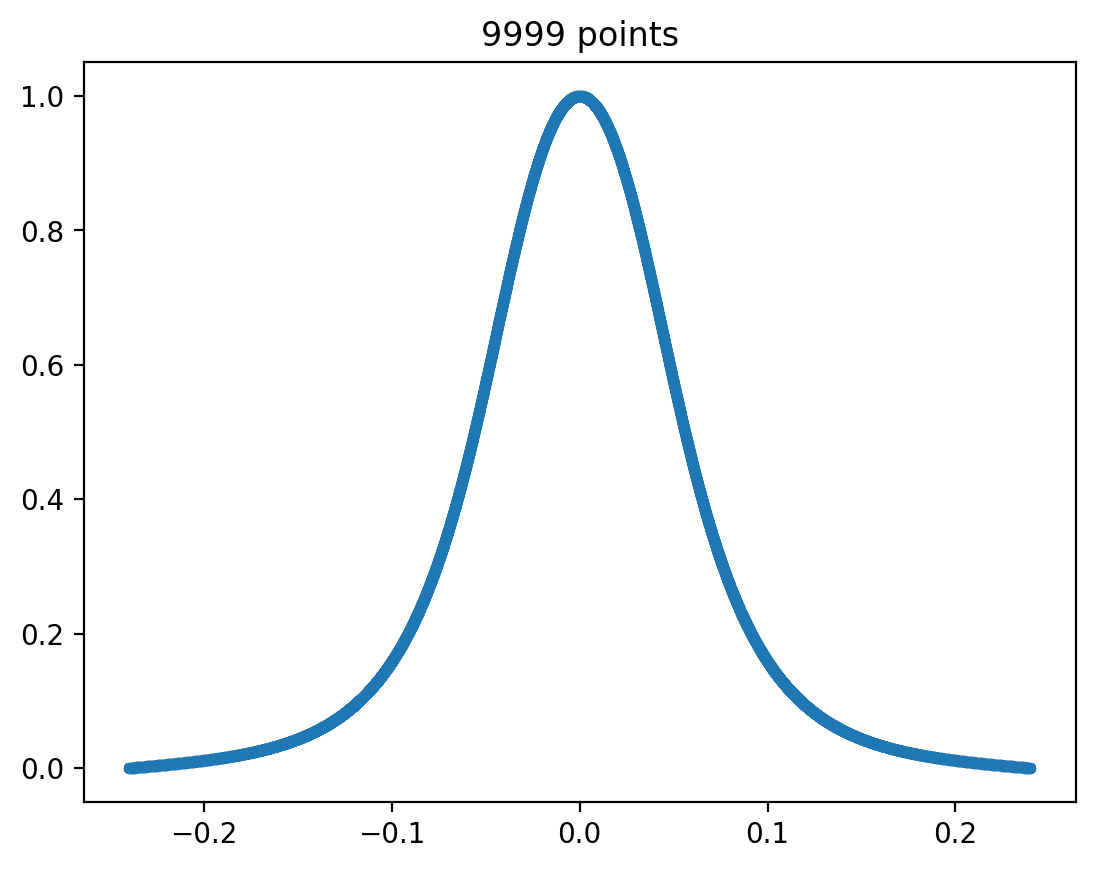

In [3]:
DAT = np.loadtxt(BDAT).T
Z, BZ = DAT[0], DAT[1]/DAT[1].max()

# Test odd number of points
Z  = Z[:-1]
BZ = BZ[:-1]

SKIP = 1 # Thin out data for visualization

Z = Z[::SKIP]
BZ = BZ[::SKIP]

# Get spacing
DZ = np.diff(Z)
assert np.allclose(DZ, DZ[0])
DZ = DZ[0]
L = np.ptp(Z)


#BZ *= sin(100*Z)

# Test for odd number of points

BZ[-1] = BZ[0] # assert periodicity

plt.plot(Z, BZ, marker='.')
plt.title(f'{len(Z)} points')

# RFcoef Fortran program

In [4]:
from pmd_beamphysics.interfaces.impact import create_fourier_coefficients

N_COEF = 20

fcoefs1 = create_fourier_coefficients(Z, BZ, n= N_COEF)

In [5]:
from impact.fieldmaps import run_RFcoef

res = run_RFcoef(Z, BZ, n_coef=N_COEF, exe="$GITHUB/IMPACT-T/utilities/RFcoeflcls")

rfdatax = res['rfdatax'] 
rfdatax2 = res['rfdatax2']
rfdataout = res['rfdata.out']
rfdatax, len(rfdatax2)

 How many Fourier coeficients you want?
 zdata1:  -0.23999999999999999       0.23995199519999999     
 The RF data number is:         9999  0.47995199519999998       -2.4002400000000534E-005   4.8004800480096016E-005
 input # of data points:
 input shift length:


(array([ 5.37408637e-01,  4.05535817e-01,  1.27428326e-04,  2.04368096e-01,
         1.28433969e-04,  8.81722122e-02,  8.31170001e-05,  2.98891171e-02,
         3.75673083e-05,  8.09723374e-03,  1.27216574e-05, -3.47962386e-04,
        -6.56022492e-07, -1.50641866e-03, -3.31345941e-06, -1.68446446e-03,
        -4.23437262e-06, -7.49162506e-04, -2.11864121e-06, -5.22801726e-04,
        -1.64275880e-06, -3.05095652e-05, -1.05460771e-07, -8.13168638e-05,
        -3.06613843e-07,  1.04233246e-04,  4.25776634e-07, -2.26873992e-05,
        -9.97976567e-08,  7.35393832e-05,  3.46610208e-07, -3.22653974e-05,
        -1.62208998e-07,  4.16143748e-05,  2.22287865e-07, -3.42199360e-05,
        -1.93540515e-07,  2.86493967e-05,  1.71035273e-07]),
 10000)

# Reconstruction


The coefficients in these files are defined so that a field $E$ can be reconstructed at position $z$ as 

$ E(z) = A_0 + \sum_{n=1}^{N} A_n \cos\left(2\pi n \frac{z}{L} \right) + B_n \sin\left(2\pi n \frac{z}{L} \right)$

where $z~\epsilon~[-L/2, L/2]$

This function will handle this efficiently.

In [6]:
from pmd_beamphysics.interfaces.impact import fourier_field_reconsruction

Text(0, 0.5, 'reconstruction error')

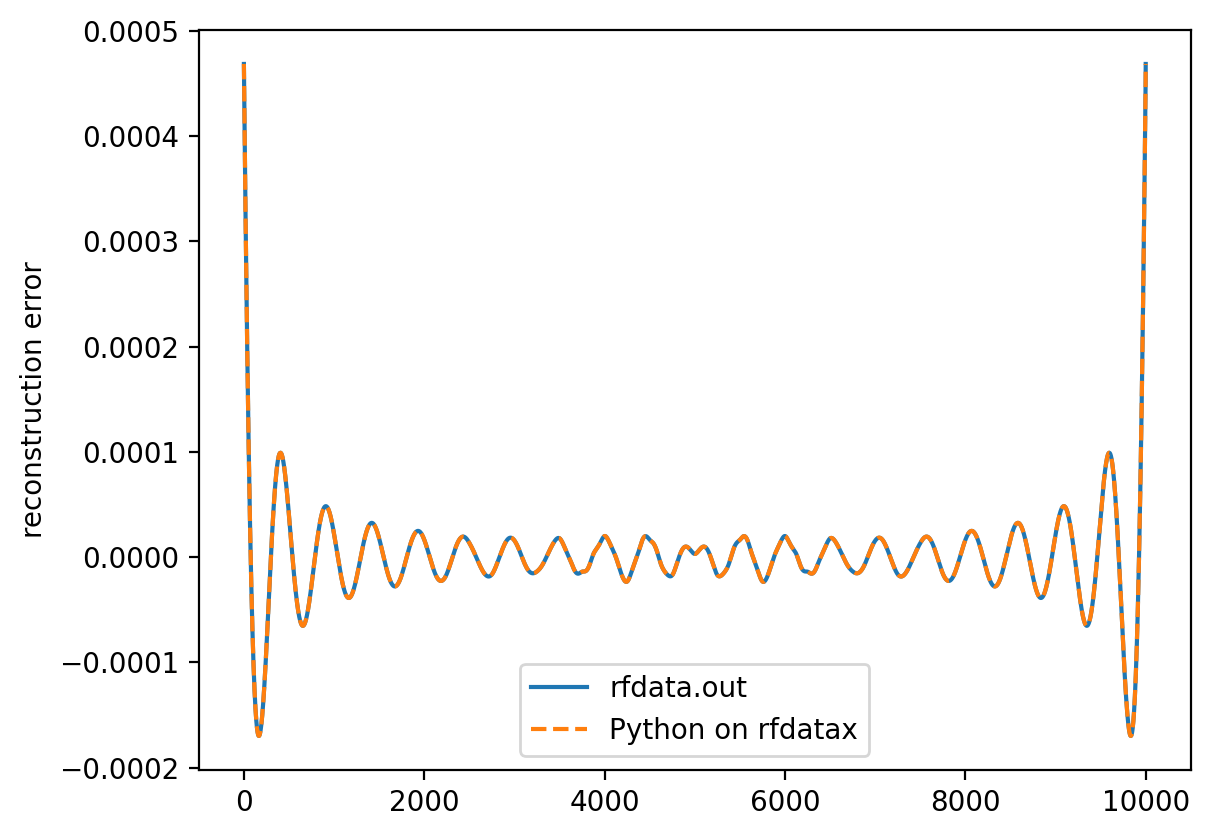

In [7]:
@np.vectorize
def f0(z):
    return fourier_field_reconsruction(z, rfdatax, z0=Z.min(), zlen=L)
    
rBZ0 = f0(Z)
errx = rfdataout[:,1] - BZ
err0 = (rBZ0 - BZ)
    
fig, ax = plt.subplots()    
#ax.plot(rBZ0, label='reconstructed')
ax.plot(errx, label='rfdata.out')
ax.plot(err0, '--', label='Python on rfdatax')
ax.legend()
ax.set_ylabel('reconstruction error')

# Create coefficients via FFT

In [8]:
from pmd_beamphysics.interfaces.impact import create_fourier_coefficients_via_fft

Text(0, 0.5, 'reconstruction error')

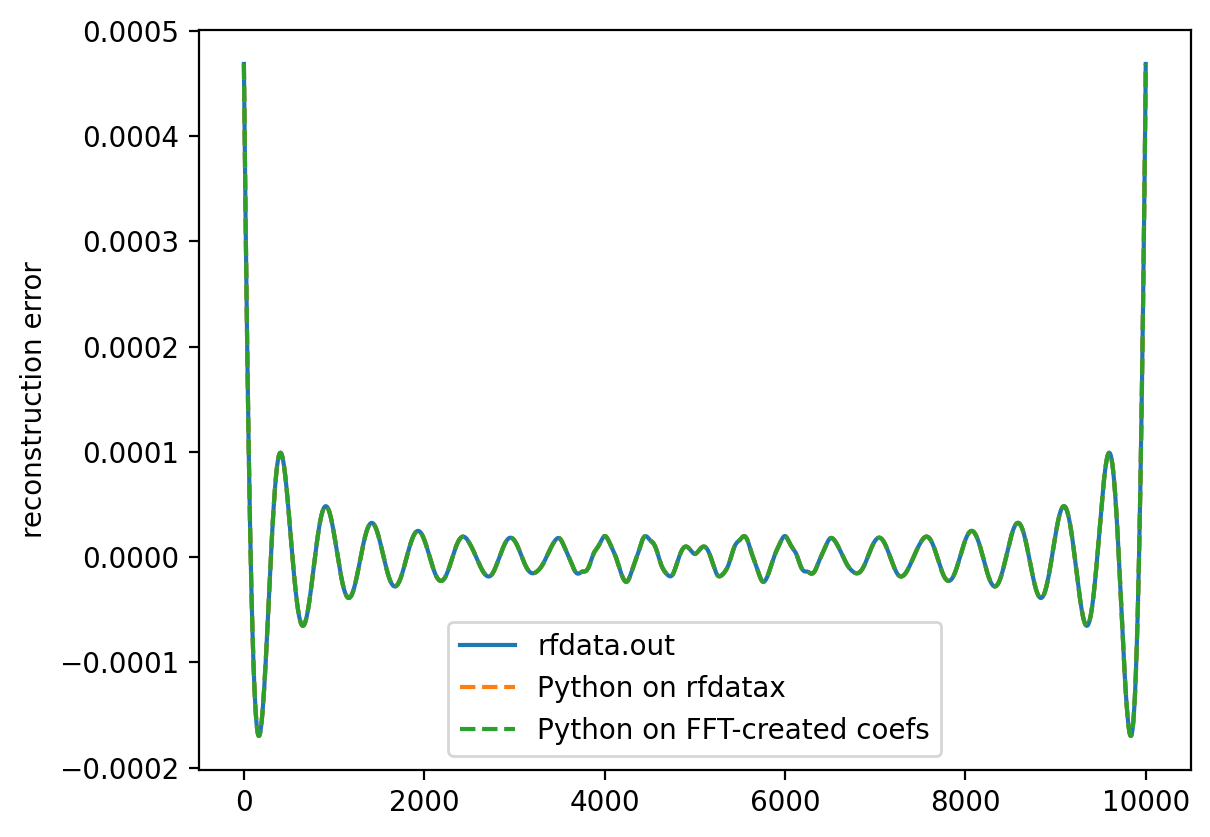

In [9]:
fcoefs1 = create_fourier_coefficients_via_fft(BZ, n_coef=N_COEF)

@np.vectorize
def f1(z):
    return fourier_field_reconsruction(z, fcoefs1, z0=Z.min(), zlen=L)

rBZ1 = f1(Z)
err1 = rBZ1 - BZ

plt.plot(errx, label='rfdata.out')
plt.plot(err0, '--', label='Python on rfdatax')
plt.plot(err1, '--', label='Python on FFT-created coefs')
plt.legend()
plt.ylabel('reconstruction error')

In [10]:
from impact import fieldmaps
?fieldmaps.create_fourier_coefficients

Signature: fieldmaps.create_fourier_coefficients(zdata, edata, n=None)
Docstring:
Literal transcription of Ji's routine RFcoeflcls.f90

https://github.com/impact-lbl/IMPACT-T/blob/master/utilities/RFcoeflcls.f90

Fixes bug with scaling the field by the max or min seen.

Vectorized two loops

Parameters
----------
zdata: ndarray
    z-coordinates

edata: ndarray
    field-coordinates

n: int
    Number of Fourier coefficient to compute.
    None => n = len(edata) //2 + 1
    Default: None

Returns
-------    
rfdata: ndarray of float
    Impact-T style Fourier coefficients
File:      ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/interfaces/impact.py
Type:      function

# Create LUME-Impact style fieldmap

In [11]:
# Get basic placement
zmin, zmax = Z.min(), Z.max()
Ltot = zmax - zmin
zmin, zmax, Ltot

(np.float64(-0.24), np.float64(0.2399519952), np.float64(0.4799519952))

In [12]:
# Create a lume-impact style fieldmap and process into flat 1D rfdata
fmap =  {'info': {'format': 'solrf'},
    'field': {'Ez': {'z0': 0.0, 'z1': 0.0, 'L': 0.0, 'fourier_coefficients': np.array([0.])},
               'Bz': {'z0': 0, 'z1': Ltot, 'L': Ltot, 'fourier_coefficients': fcoefs1 }
             } }
    

rfdata = fieldmaps.data_from_solrf_fieldmap(fmap)    
rfdata

array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.90000000e+01,  0.00000000e+00,  4.79951995e-01,
        4.79951995e-01,  5.37408637e-01,  4.05535823e-01,  1.27428326e-04,
        2.04368105e-01,  1.28433972e-04,  8.81722191e-02,  8.31170052e-05,
        2.98891211e-02,  3.75673126e-05,  8.09723557e-03,  1.27216601e-05,
       -3.47961770e-04, -6.56021318e-07, -1.50641859e-03, -3.31345921e-06,
       -1.68446459e-03, -4.23437286e-06, -7.49162657e-04, -2.11864160e-06,
       -5.22801825e-04, -1.64275909e-06, -3.05096309e-05, -1.05460998e-07,
       -8.13168795e-05, -3.06613895e-07,  1.04233233e-04,  4.25776572e-07,
       -2.26873865e-05, -9.97975973e-08,  7.35393794e-05,  3.46610182e-07,
       -3.22653834e-05, -1.62208922e-07,  4.16143681e-05,  2.22287823e-07,
       -3.42199254e-05, -1.93540450e-07,  2.86493873e-05,  1.71035211e-07])

In [13]:
# This simply writes 'data' this to a file
fieldmaps.write_fieldmap('templates/solenoid/rfdata666', fmap)

In [14]:
zcenter = 0.24653 # Intended center

ele = {'description': 'name:SOL1B',
 'L': Ltot,
 'type': 'solrf',
 'zedge': zcenter + zmin,
 'rf_field_scale': 0.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': 'rfdata666',
 'radius': 0.15,
 'x_offset': 0.0,
 'y_offset': 0.0,
 'x_rotation': 0.0,
 'y_rotation': 0.0,
 'z_rotation': 0.0,
 'solenoid_field_scale': 0.057,
 'name': 'SOL1'}
ele

{'description': 'name:SOL1B',
 'L': np.float64(0.4799519952),
 'type': 'solrf',
 'zedge': np.float64(0.006530000000000008),
 'rf_field_scale': 0.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': 'rfdata666',
 'radius': 0.15,
 'x_offset': 0.0,
 'y_offset': 0.0,
 'x_rotation': 0.0,
 'y_rotation': 0.0,
 'z_rotation': 0.0,
 'solenoid_field_scale': 0.057,
 'name': 'SOL1'}

In [15]:
import impact
# This is the line to add to ImpactT.in
impact.lattice.ele_line(ele)

'0.4799519952 0 0 105 0.006530000000000008 0.0 0.0 0.0 666 0.15 0.0 0.0 0.0 0.0 0.0 0.057 /!name:SOL1'

# New-style solRF field

 How many Fourier coeficients you want?
 zdata1:   -6.0000000000000000        6.0000000000000000     
 The RF data number is:         1000   12.000000000000000        0.0000000000000000        1.2012012012012012E-002
 input # of data points:
 input shift length:


((1000, 4), (1000, 4))

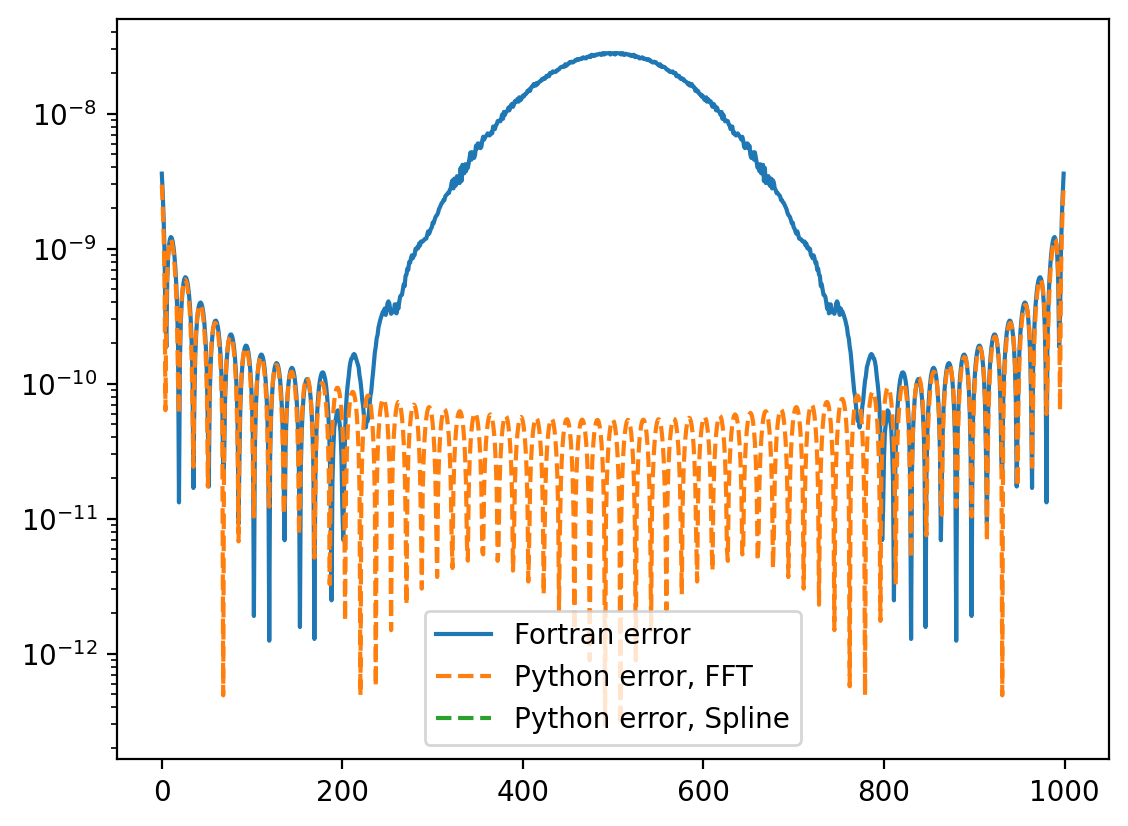

In [16]:
from pmd_beamphysics.fields.expansion import fft_derivative_array, spline_derivative_array
from impact.fieldmaps import run_RFcoef


from numpy import sqrt, pi, exp
def gaussian_derivatives(z):
    f0 =  1/sqrt(2*pi) *exp(- z**2 / 2)    
    return np.array([1* f0,
                     (-z) * f0, 
                     (-1 + z**2) * f0, 
                     (3*z - z**3)* f0]).T

ZZ = np.linspace(-6, 6, 1000)
DZ = np.diff(ZZ)[0]

AFZ = gaussian_derivatives(ZZ)
AFZ /= AFZ[:,0].max() # Normalize for comparisons

FZ = AFZ[:,0]

N_COEF = 30
rfdatax2 = run_RFcoef(ZZ, FZ, n_coef=N_COEF, exe="$GITHUB/IMPACT-T/utilities/RFcoeflcls")['rfdatax2'][1:]
myrfdatax2 = fft_derivative_array(FZ, ncoef = N_COEF, dz=DZ)

myrfdatax2_spline = spline_derivative_array(ZZ, FZ)


ORDER = 0
plt.plot(abs(  rfdatax2[:,ORDER] - AFZ[:, ORDER]), label='Fortran error')#
plt.plot(abs(myrfdatax2[:,ORDER] - AFZ[:, ORDER]), '--', label='Python error, FFT')#
plt.plot(abs(myrfdatax2_spline[:,ORDER] - AFZ[:, ORDER]), '--', label='Python error, Spline')#
plt.legend()
plt.yscale('log')


rfdatax2.shape, myrfdatax2.shape

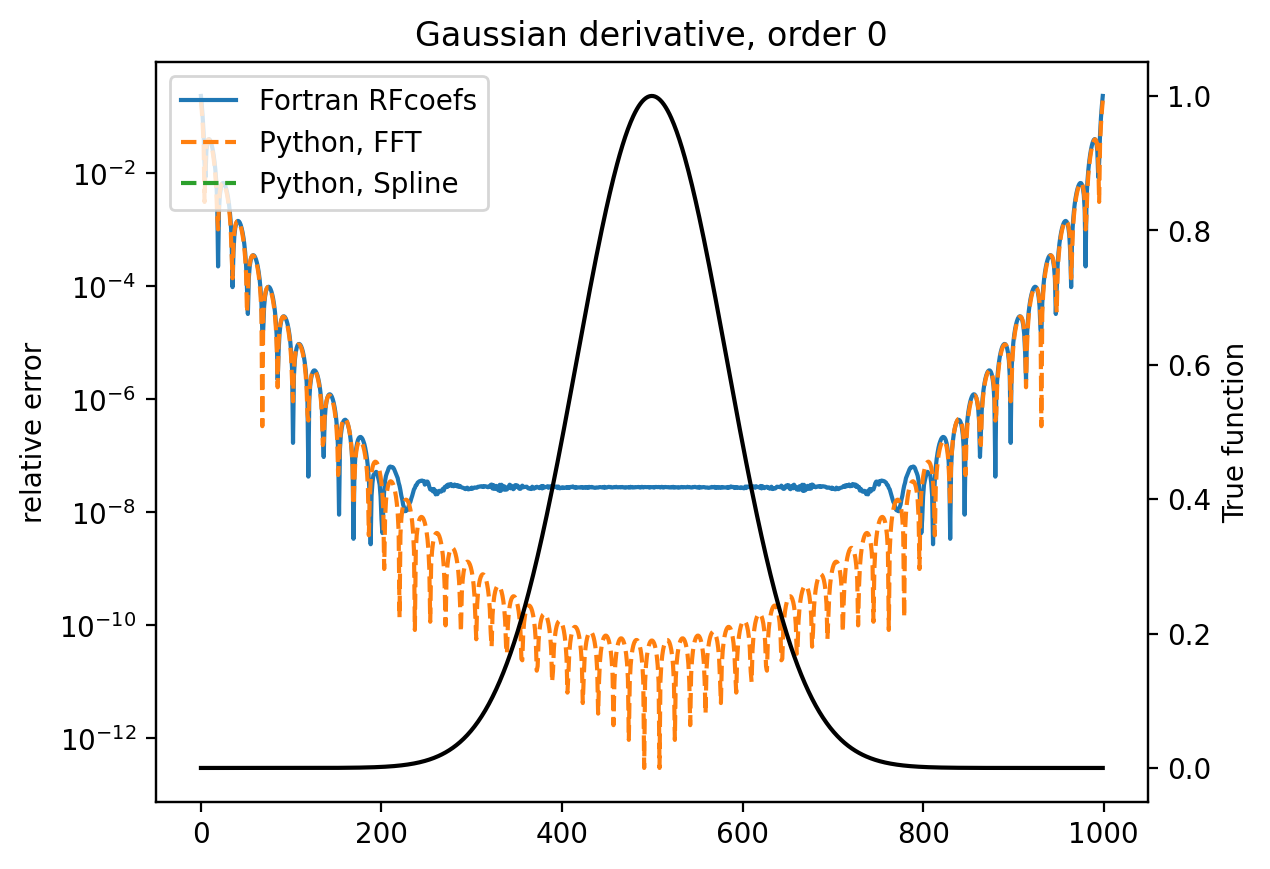

In [17]:
def compare(order):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    
    f0 = AFZ[:,order]
    f1 = rfdatax2[:,order]
    f2 = myrfdatax2[:,order]
    f3 = myrfdatax2_spline[:,order]
    
    err1 = abs((f1-f0)/f0)
    err2 = abs((f2-f0)/f0)
    err3 = abs((f3-f0)/f0)
    ax2.plot( f0   , label='Reference', color='black')#
    #ax2.plot( f1   , label='Fortran')#
    #ax2.plot( f2, '--', label='Python, FFT')#
    #ax2.plot( f3, '--', label='Python, Spline')#
    #ax2.legend(loc='upper right')
    
    ax.set_title(f'Gaussian derivative, order {order}')
    ax.set_ylabel('relative error')
    ax2.set_ylabel('True function')
    ax.plot( err1   , label='Fortran RFcoefs')#
    ax.plot( err2, '--', label='Python, FFT')#
    ax.plot( err3, '--', label='Python, Spline')#
    ax.set_yscale('log')
    ax.legend(loc='upper left')
    
compare(0)    

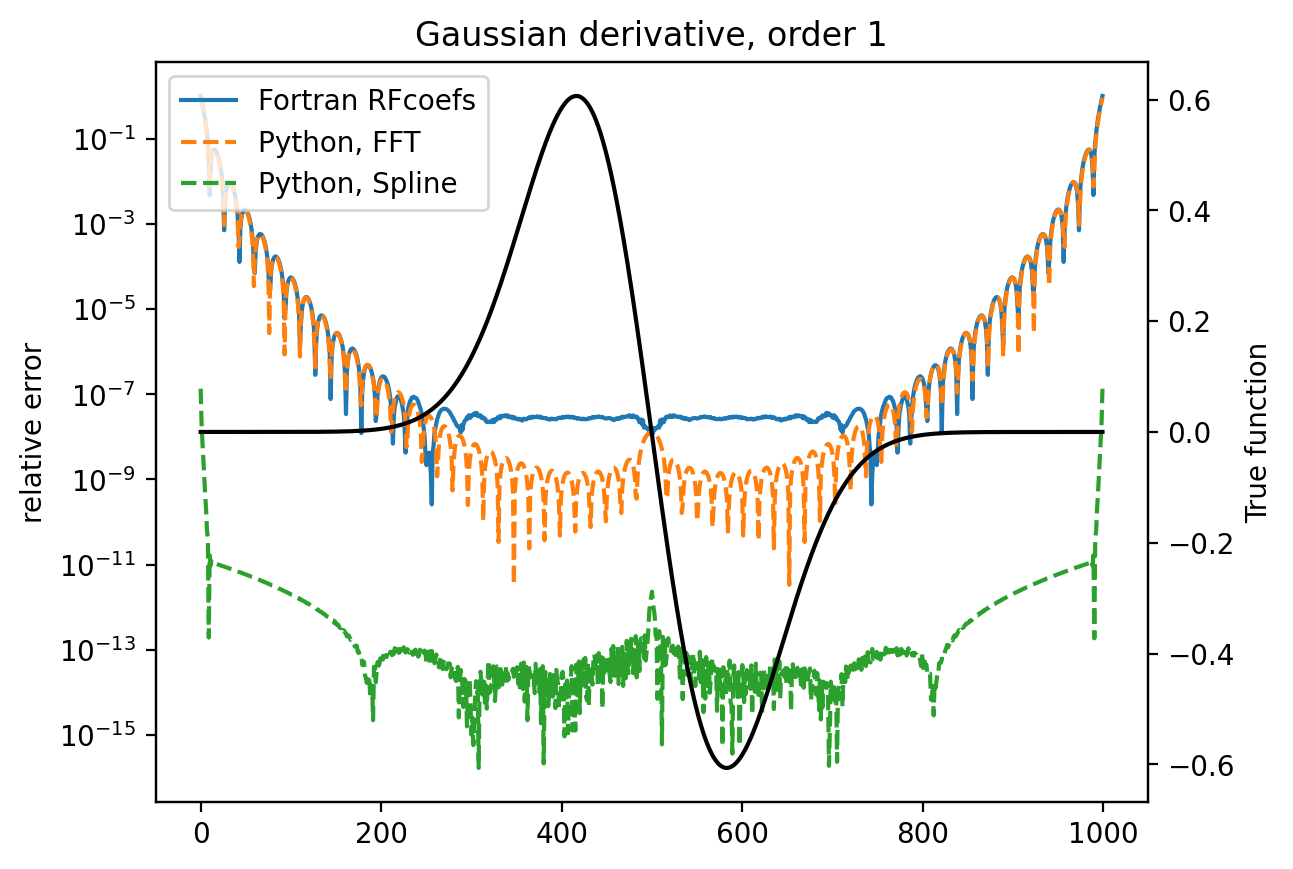

In [18]:
compare(1) 

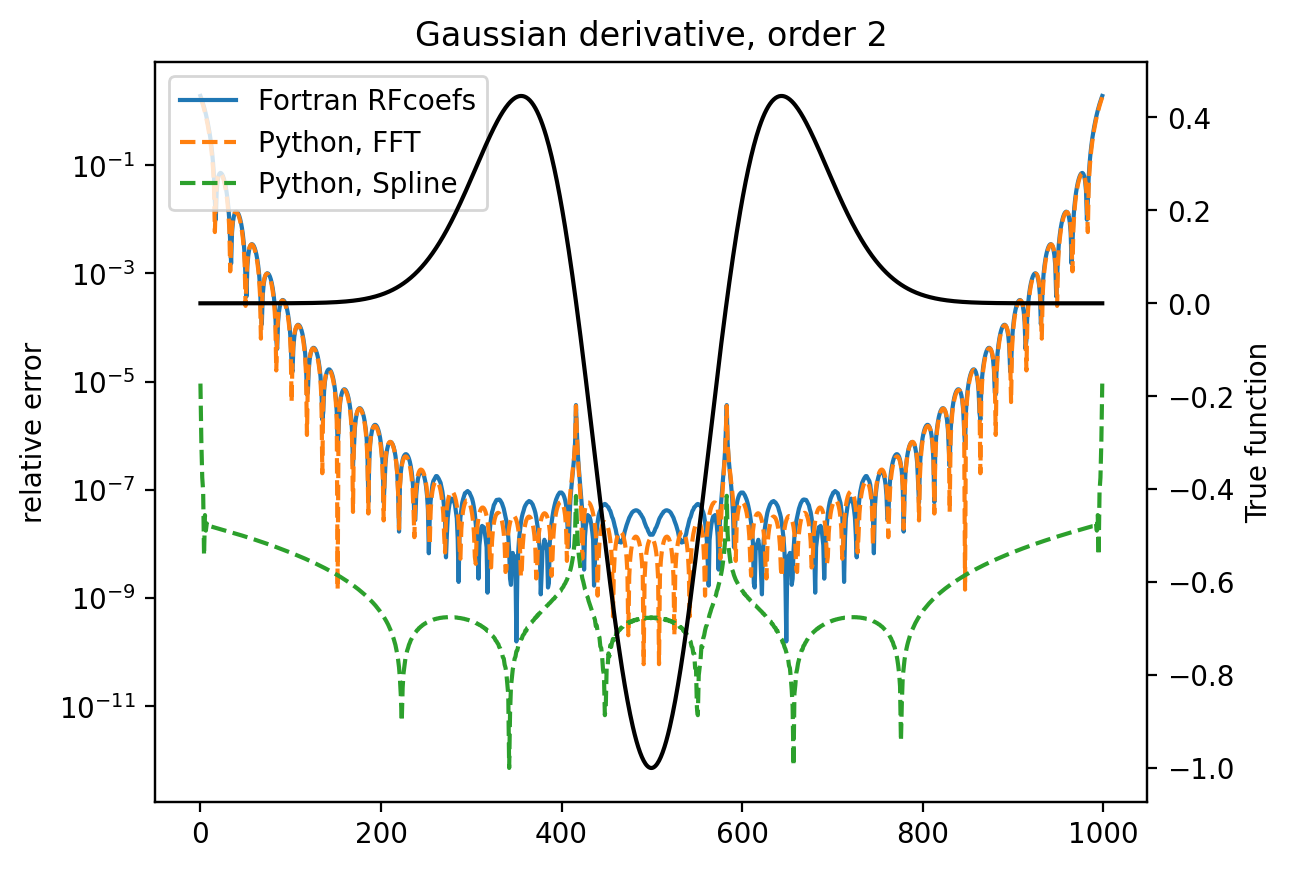

In [19]:
compare(2) 

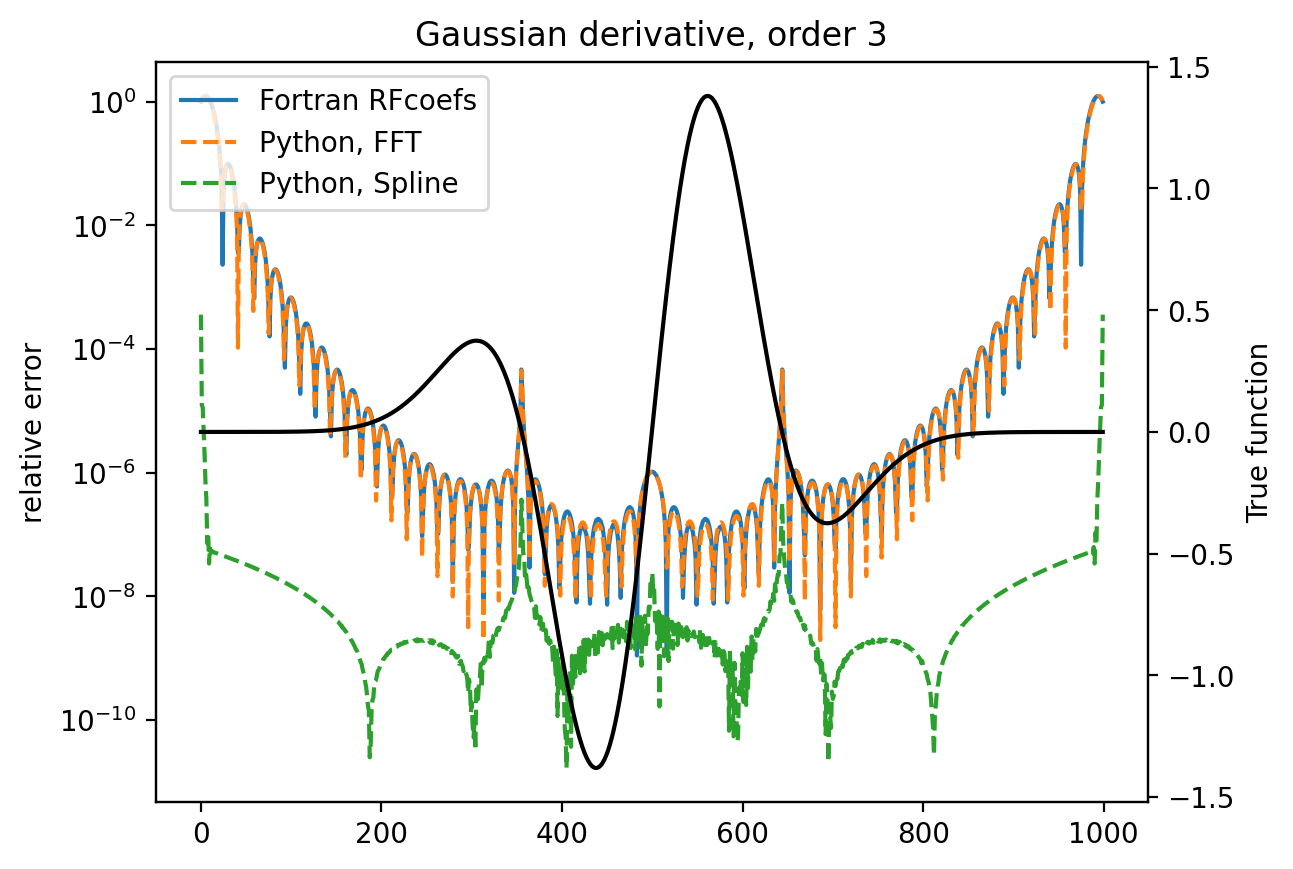

In [20]:
compare(3) 